In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cnn-model/Leaf that not to be used to make tea-20251023T175713Z-1-001/Leaf that not to be used to make tea/IMG20230816192835.jpg
/kaggle/input/cnn-model/Leaf that not to be used to make tea-20251023T175713Z-1-001/Leaf that not to be used to make tea/IMG20230816204543(1).jpg
/kaggle/input/cnn-model/Leaf that not to be used to make tea-20251023T175713Z-1-001/Leaf that not to be used to make tea/IMG20230816200501.jpg
/kaggle/input/cnn-model/Leaf that not to be used to make tea-20251023T175713Z-1-001/Leaf that not to be used to make tea/IMG20230816194437.jpg
/kaggle/input/cnn-model/Leaf that not to be used to make tea-20251023T175713Z-1-001/Leaf that not to be used to make tea/IMG20230816194409.jpg
/kaggle/input/cnn-model/Leaf that not to be used to make tea-20251023T175713Z-1-001/Leaf that not to be used to make tea/IMG20230816203810.jpg
/kaggle/input/cnn-model/Leaf that not to be used to make tea-20251023T175713Z-1-001/Leaf that not to be used to make tea/IMG20230816200735.

In [60]:

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from torchvision.models import resnet18
from tqdm import tqdm


In [61]:

DATA_DIR = "/kaggle/input/cnn-model"   # your dataset path
OUTPUT_DIR = "/kaggle/working"         # output path for saving model

print("Data Directory:", DATA_DIR)
print("Output Directory:", OUTPUT_DIR)


Data Directory: /kaggle/input/cnn-model
Output Directory: /kaggle/working


**Preprocessing+Data Augmentation:**

In [74]:

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])


**LOAD DATASET:**

In [75]:

full_dataset = datasets.ImageFolder(DATA_DIR)
class_names = full_dataset.classes
num_classes = len(class_names)

print("Classes:", class_names)
print("Total Images:", len(full_dataset))


Classes: ['Leaf that not to be used to make tea-20251023T175713Z-1-001', 'Leaf that uses to make tea-20251023T175715Z-1-001']
Total Images: 747


**Split into Train/Val/Test:**

In [76]:

total_len = len(full_dataset)
train_len = int(0.7 * total_len)
val_len = int(0.2 * total_len)
test_len = total_len - train_len - val_len

train_ds, val_ds, test_ds = random_split(full_dataset, [train_len, val_len, test_len])

# Apply separate transforms
train_ds.dataset.transform = train_transform
val_ds.dataset.transform = val_test_transform
test_ds.dataset.transform = val_test_transform

print(len(train_ds), len(val_ds), len(test_ds))


522 149 76


**DATA LOADERS:**

In [77]:

BATCH_SIZE = 32

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False)


**Custom CNN Model:**

In [78]:

class CustomCNN(nn.Module):
    def __init__(self, num_classes):
        super(CustomCNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 112x112

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 56x56

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 28x28

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2),  # 14x14

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2)   # 7x7
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 7 * 7, 512),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

device = "cuda" if torch.cuda.is_available() else "cpu"
model = CustomCNN(num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)


**Train and Validation function:**

In [79]:

def train_one_epoch(loader):
    model.train()
    running_loss = 0
    correct = 0
    total = 0

    for imgs, labels in tqdm(loader):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * imgs.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    return running_loss / total, correct / total


def validate(loader):
    model.eval()
    running_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * imgs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    return running_loss / total, correct / total


In [80]:

#  — Early Stopping Setup
best_val_loss = float("inf")
patience = 3
wait = 0


In [81]:
# Training Loop with Early Stopping

EPOCHS = 5 # early stopping prevents overfitting

train_losses, val_losses = [], []

for epoch in range(EPOCHS):
    train_loss, train_acc = train_one_epoch(train_loader)
    val_loss, val_acc = validate(val_loader)

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f"\nEpoch {epoch+1}/{EPOCHS}")
    print(f" Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f" Val Loss  : {val_loss:.4f} | Val Acc  : {val_acc:.4f}")

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        wait = 0
        best_model_path = os.path.join(OUTPUT_DIR, "best_cnn_model.pth")
        torch.save(model.state_dict(), best_model_path)
        print(" ** Saved Best Model **")
    else:
        wait += 1
        if wait >= patience:
            print("\nEarly stopping triggered!")
            break


100%|██████████| 17/17 [02:38<00:00,  9.33s/it]



Epoch 1/5
 Train Loss: 1.6847 | Train Acc: 0.8161
 Val Loss  : 2.4922 | Val Acc  : 0.4497
 ** Saved Best Model **


100%|██████████| 17/17 [02:34<00:00,  9.10s/it]



Epoch 2/5
 Train Loss: 0.3357 | Train Acc: 0.9291
 Val Loss  : 1.1917 | Val Acc  : 0.5705
 ** Saved Best Model **


100%|██████████| 17/17 [02:35<00:00,  9.14s/it]



Epoch 3/5
 Train Loss: 0.4096 | Train Acc: 0.8774
 Val Loss  : 0.1374 | Val Acc  : 0.9463
 ** Saved Best Model **


100%|██████████| 17/17 [02:36<00:00,  9.18s/it]



Epoch 4/5
 Train Loss: 0.1924 | Train Acc: 0.9425
 Val Loss  : 0.2959 | Val Acc  : 0.9060


100%|██████████| 17/17 [02:38<00:00,  9.31s/it]



Epoch 5/5
 Train Loss: 0.2090 | Train Acc: 0.9464
 Val Loss  : 0.0587 | Val Acc  : 0.9732
 ** Saved Best Model **


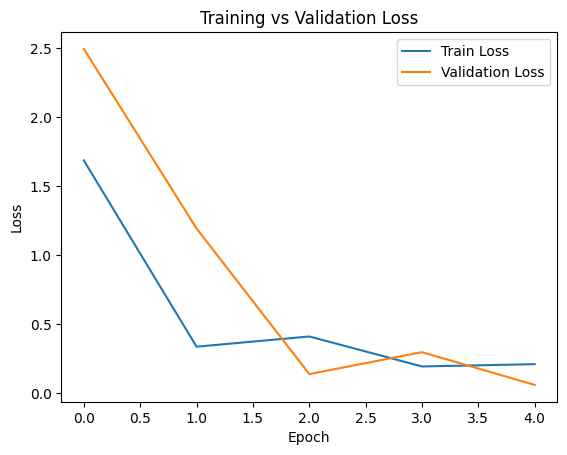

In [82]:
# — Training Curves

plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


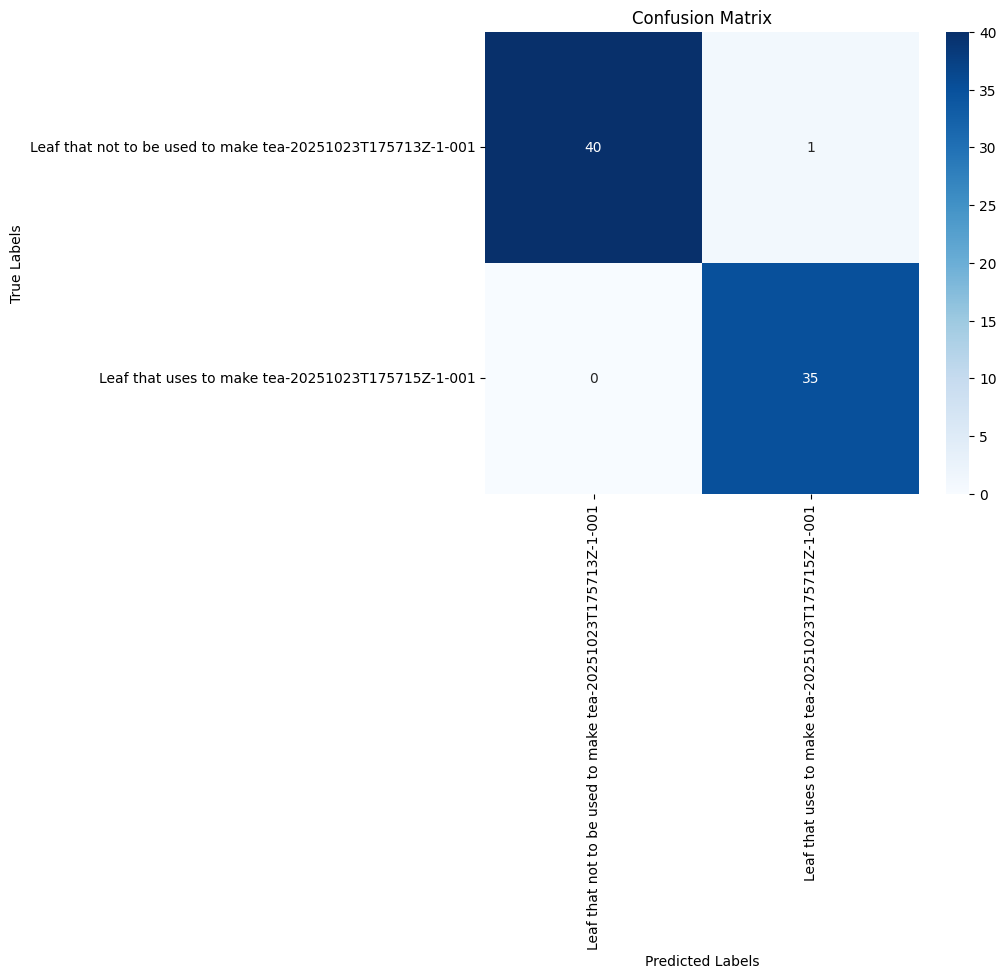

In [85]:

# Confusion Matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd

# Get predictions for test set
y_true = []
y_pred = []

model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, "best_cnn_model.pth")))
model.eval()

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        _, predicted = outputs.max(1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)

plt.figure(figsize=(7,6))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("True Labels")
plt.xlabel("Predicted Labels")
plt.show()


**Per class accuracy:**

In [87]:

from sklearn.metrics import classification_report
import numpy as np

# Get predictions again (safe)
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for imgs, labels in test_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        _, predicted = outputs.max(1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())



print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))


# ======== Per-class accuracy ========
total_classes = len(class_names)
class_correct = [0] * total_classes
class_total = [0] * total_classes

for i in range(len(y_true)):
    label = y_true[i]
    pred = y_pred[i]

    if label == pred:
        class_correct[label] += 1
    class_total[label] += 1

print()
for i, cls in enumerate(class_names):
    acc = class_correct[i] / class_total[i]
    print(f"{cls} Accuracy: {acc:.3f}")



Classification Report:

                                                             precision    recall  f1-score   support

Leaf that not to be used to make tea-20251023T175713Z-1-001       1.00      0.98      0.99        41
          Leaf that uses to make tea-20251023T175715Z-1-001       0.97      1.00      0.99        35

                                                   accuracy                           0.99        76
                                                  macro avg       0.99      0.99      0.99        76
                                               weighted avg       0.99      0.99      0.99        76


Leaf that not to be used to make tea-20251023T175713Z-1-001 Accuracy: 0.976
Leaf that uses to make tea-20251023T175715Z-1-001 Accuracy: 1.000


In [86]:

#  — Final Test Evaluation

model.load_state_dict(torch.load(os.path.join(OUTPUT_DIR, "best_cnn_model.pth")))

test_loss, test_acc = validate(test_loader)

print("\n=== Final Test Accuracy ===")
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Acc : {test_acc:.4f}")



=== Final Test Accuracy ===
Test Loss: 0.0836
Test Acc : 0.9868
